In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
from PIL import Image
import seaborn as sn
import matplotlib.pyplot as plt
import os
from natsort import natsorted
from tqdm import tqdm
import cv2
import skvideo.io



from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_score
import seaborn as sns

In [2]:
file_paths = {'11': '/Users/julianna/Desktop/kinematic_df/participant_dataframes/11.csv',
 '12': '/Users/julianna/Desktop/kinematic_df/participant_dataframes/12.csv',
 '13': '/Users/julianna/Desktop/kinematic_df/participant_dataframes/13.csv',
 '14': '/Users/julianna/Desktop/kinematic_df/participant_dataframes/14.csv',
 '15': '/Users/julianna/Desktop/kinematic_df/participant_dataframes/15.csv',
 '19': '/Users/julianna/Desktop/kinematic_df/participant_dataframes/19.csv',
 '21': '/Users/julianna/Desktop/kinematic_df/participant_dataframes/21.csv',
 '22': '/Users/julianna/Desktop/kinematic_df/participant_dataframes/22.csv',
 '23': '/Users/julianna/Desktop/kinematic_df/participant_dataframes/23.csv',
 '24': '/Users/julianna/Desktop/kinematic_df/participant_dataframes/24.csv',
 '29': '/Users/julianna/Desktop/kinematic_df/participant_dataframes/29.csv',
 '30': '/Users/julianna/Desktop/kinematic_df/participant_dataframes/30.csv',
 '35': '/Users/julianna/Desktop/kinematic_df/participant_dataframes/35.csv',
 '36': '/Users/julianna/Desktop/kinematic_df/participant_dataframes/36.csv',
 '38': '/Users/julianna/Desktop/kinematic_df/participant_dataframes/38.csv',
 '47': '/Users/julianna/Desktop/kinematic_df/participant_dataframes/47.csv',
 '52': '/Users/julianna/Desktop/kinematic_df/participant_dataframes/52.csv',
 '54': '/Users/julianna/Desktop/kinematic_df/participant_dataframes/54.csv',
 '60': '/Users/julianna/Desktop/kinematic_df/participant_dataframes/60.csv',
 '82': '/Users/julianna/Desktop/kinematic_df/participant_dataframes/82.csv'}

# Initialize an empty dictionary to hold your DataFrames
participant_dataframes = {}

# Loop over the file_paths dictionary and read each CSV file into a DataFrame
for name, file_path in file_paths.items():
    participant_dataframes[name] = pd.read_csv(file_path)


In [3]:
participant_dataframes['21']

,frame_name,fid,class,bb0,bb1,bb2,bb3,ID,center_x_pixels,center_y_pixels,center_x_um,center_y_um,frame_number,delta_x,delta_y
0,21_frame_0_with_ftid,ckz3vwyqh000r3867ejpqrh3v,0,0.184375,0.166667,0.025000,0.033333,21,118.000000,80.0,245.833333,166.666667,0,0.000000,0.0
1,21_frame_1_with_ftid,ckz3vwyqh000r3867ejpqrh3v,0,0.184346,0.166667,0.025000,0.033333,21,117.981567,80.0,245.794931,166.666667,1,-0.038402,0.0
2,21_frame_2_with_ftid,ckz3vwyqh000r3867ejpqrh3v,0,0.184317,0.166667,0.025000,0.033333,21,117.963134,80.0,245.756528,166.666667,2,-0.038402,0.0
3,21_frame_3_with_ftid,ckz3vwyqh000r3867ejpqrh3v,0,0.184289,0.166667,0.025000,0.033333,21,117.944700,80.0,245.718126,166.666667,3,-0.038402,0.0
4,21_frame_4_with_ftid,ckz3vwyqh000r3867ejpqrh3v,0,0.184260,0.166667,0.025000,0.033333,21,117.926267,80.0,245.679724,166.666667,4,-0.038402,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32505,21_frame_748_with_ftid,cl522zdjv000f3r6gd65erki8,2,0.053906,0.406250,0.020313,0.033333,21,34.500000,195.0,71.875000,406.250000,748,0.000000,0.0
32506,21_frame_749_with_ftid,cl522zdjv000f3r6gd65erki8,2,0.053906,0.406250,0.020313,0.033333,21,34.500000,195.0,71.875000,406.250000,749,0.000000,0.0
32507,21_frame_750_with_ftid,cl522zdjv000f3r6gd65erki8,2,0.053906,0.406250,0.020313,0.033333,21,34.500000,195.0,71.875000,406.250000,750,0.000000,0.0
32508,21_frame_751_with_ftid,cl522zdjv000f3r6gd65erki8,2,0.053906,0.406250,0.020313,0.033333,21,34.500000,195.0,71.875000,406.250000,751,0.000000,0.0


For the coordinate and row problem, if the calculations in this java script are based on the current rows actual coordinates and the next row's average coordinates, then I want to keep my code, if not then lets adapt the code so that it compares the same rows actual and averaged coordinates. (we want to make sure we are still looking at segments though, which may be why we are looking at the next rows coordinates


In [4]:
def moving_average(series, window_size=3):
    return series.rolling(window=window_size, min_periods=1, center=True).mean()

def apply_moving_average(df, window_size=3):
    df['avg_center_x_um'] = df.groupby('fid')['center_x_um'].transform(lambda x: moving_average(x, window_size))
    df['avg_center_y_um'] = df.groupby('fid')['center_y_um'].transform(lambda x: moving_average(x, window_size))
    return df

def distance_between_segments(seg1_start, seg1_end, seg2_start, seg2_end):
    def orientation(point1, point2):
        dx = point2[0] - point1[0]
        dy = point2[1] - point1[1]
        if dx == 0:
            if dy != 0:
                return "VERTICAL"
            else:
                return "NULL"
        else:
            if dy == 0:
                return "HORIZONTAL"
            else:
                return "OBLIQUE"

    def distance(point1, point2):
        dx = point2[0] - point1[0]
        dy = point2[1] - point1[1]
        return (dx ** 2 + dy ** 2) ** 0.5

    segment_p_orientation = orientation(seg1_start, seg1_end)
    segment_q_orientation = orientation(seg2_start, seg2_end)

    vp = [seg1_end[0] - seg1_start[0], seg1_end[1] - seg1_start[1]]
    vq = [seg2_end[0] - seg2_start[0], seg2_end[1] - seg2_start[1]]

    if vp[0] == 0:
        if vp[1] != 0:
            segment_p_orientation = "VERTICAL"
        else:
            segment_p_orientation = "NULL"
            return 0.0

    if vq[0] == 0:
        if vq[1] != 0:
            segment_q_orientation = "VERTICAL"
        else:
            segment_q_orientation = "NULL"
            return 0.0

    if (
        (segment_p_orientation == "VERTICAL" and segment_q_orientation == "HORIZONTAL")
        or (segment_p_orientation == "HORIZONTAL" and segment_q_orientation == "VERTICAL")
    ):
        return 0.0

    mp, np, mq, nq = 0, 0, 0, 0

    if segment_p_orientation != "VERTICAL":
        mp = vp[1] / vp[0]
        np = seg1_end[1] - mp * seg1_end[0]

    qm = [(seg2_start[0] + seg2_end[0]) / 2, (seg2_start[1] + seg2_end[1]) / 2]

    if segment_q_orientation != "HORIZONTAL":
        mq = -vq[0] / vq[1]
        nq = qm[1] - mq * qm[0]

    if segment_p_orientation == "VERTICAL" and segment_q_orientation == "OBLIQUE":
        xi = seg1_start[0]
        yi = mq * xi + nq
        intersection = [xi, yi]
        if seg1_start[0] <= xi <= seg1_end[0] or seg1_end[0] <= xi <= seg1_start[0]:
            return distance(intersection, qm)
        else:
            return 0.0

    if segment_p_orientation == "OBLIQUE" and segment_q_orientation == "HORIZONTAL":
        xi = qm[0]
        yi = mp * xi + np
        intersection = [xi, yi]
        if seg2_start[1] <= yi <= seg2_end[1] or seg2_end[1] <= yi <= seg2_start[1]:
            return distance(intersection, qm)
        else:
            return 0.0

    if mp == mq:
        return 0.0

    xi = (nq - np) / (mp - mq)
    yi = mp * xi + np
    intersection = [xi, yi]

    if seg1_start[0] <= xi <= seg1_end[0] or seg1_end[0] <= xi <= seg1_start[0]:
        return distance(intersection, qm)
    else:
        return 0.0

def calculate_segment_distances(df, window_size):
    # Add columns for segment start and end in actual and average tracks
    df['seg_actual_start'] = df[['center_x_um', 'center_y_um']].apply(tuple, axis=1)
    df['seg_actual_end'] = df[['center_x_um', 'center_y_um']].shift(-1).apply(tuple, axis=1)
    df['seg_avg_start'] = df[['avg_center_x_um', 'avg_center_y_um']].apply(tuple, axis=1)
    df['seg_avg_end'] = df[['avg_center_x_um', 'avg_center_y_um']].shift(-1).apply(tuple, axis=1)

    # Initialize a column to store the riser values
    df['riser'] = np.nan

    for fid, group in df.groupby('fid'):
        # Ensure group is sorted by frame_number or equivalent
        group = group.sort_values(by='frame_number')
        for j in range(len(group) - window_size):
            min_dist = float('inf')
            for k in range(j, j + window_size - 1):
                # Get the actual and average segments
                actual_start = group.iloc[k]['seg_actual_start']
                actual_end = group.iloc[k]['seg_actual_end']
                avg_start = group.iloc[j]['seg_avg_start']
                avg_end = group.iloc[j]['seg_avg_end']

                # Calculate the distance between segments
                dist = distance_between_segments(actual_start, actual_end, avg_start, avg_end)
                min_dist = min(min_dist, dist)
            
            # Assign the minimum distance to the riser column
            df.loc[group.index[j], 'riser'] = min_dist

    return df

def calculate_alh(df):
    # Calculate the 'riser' values using calculate_segment_distances
    df = calculate_segment_distances(df, window_size=3)

    alh_results = []
    for fid, group in df.groupby('fid'):
        alh_max = group['riser'].max()  # Maximum riser value in the group
        alh_mean = group['riser'].mean()  # Mean riser value in the group

        # Assuming Params.micronPerPixel is a known scaling factor
        micron_per_pixel = 1 / 0.48   # Replace with actual value
        alh_results.append({'fid': fid, 'ALH Mean': 2 * alh_mean * micron_per_pixel, 'ALH Max': 2 * alh_max * micron_per_pixel})

    return pd.DataFrame(alh_results)

In [8]:
df = participant_dataframes['21']
apply_moving_average(df, window_size = 3)
calculate_segment_distances(df, window_size = 3)
calculate_alh(df)

,fid,ALH Mean,ALH Max
0,ckz3vwyqh000r3867ejpqrh3v,0.000000,0.000000
1,cl3l9s21y00043r6c9z22mg77,0.000000,0.000000
2,cl3l9sbf400083r6cvbbylvw8,0.180161,25.709111
3,cl3l9sibg000c3r6cny8ys6gz,0.000036,0.026795
4,cl3l9sm3z000g3r6c1mykp9ux,0.000000,0.000000
...,...,...,...
75,cl3lk7rxk008e3r6cvl9tfyaz,0.082837,9.095538
76,cl3lkeq6n008i3r6cdzw9qe25,0.000000,0.000000
77,cl3lkfleb008m3r6c4f15engp,0.132960,8.047793
78,cl522yttk000b3r6gtxj0zvyx,0.000000,0.000000


In [14]:


# Assuming apply_moving_average and calculate_segment_distances functions are defined
# Assuming calculate_alh function is as you provided

# Initialize an empty dictionary to store the ALH DataFrame for each participant
alh_dataframes = {}

window_size = 3  # Set the window size for moving average and segment distance calculations

# Iterate over all participants with a progress bar
for participant_key, df in tqdm(list(participant_dataframes.items()), desc="Processing Participants"):
    # Apply the moving average
    apply_moving_average(df, window_size)

    # Calculate segment distances
    calculate_segment_distances(df, window_size)

    # Calculate ALH, which already includes the mean and max calculations
    alh_df = calculate_alh(df)

    # Store the resulting ALH DataFrame in the dictionary, keyed by the participant ID
    alh_dataframes[participant_key] = alh_df

# Now, alh_dataframes contains the ALH data for each participant as separate DataFrames







Processing Participants: 100%|██████████████████| 20/20 [05:14<00:00, 15.71s/it]


In [16]:
alh_dataframes

{'11':                           fid      ALH Mean       ALH Max
 0   ckz3v9nzv00033867jsekqdcl  0.000000e+00  0.000000e+00
 1   ckz6ru2eb0001386lefk6js4m  0.000000e+00  0.000000e+00
 2   ckz6ru3um0003386l39xwv0yk  0.000000e+00  0.000000e+00
 3   ckz6ru5610005386l8uoys4lc  0.000000e+00  0.000000e+00
 4   ckz6ru6of0007386lhf2t4dtw  0.000000e+00  0.000000e+00
 5   ckz6ru83f0009386lx7517dwf  0.000000e+00  0.000000e+00
 6   ckz6ru99l000b386l18xh2byu  0.000000e+00  0.000000e+00
 7   ckz6rub67000d386ld3mx1dyi  1.506030e+09  2.209345e+12
 8   ckz6ruchb000f386lxxpeu5na  0.000000e+00  0.000000e+00
 9   ckz6rudsb000h386lkwwvc8dz  0.000000e+00  0.000000e+00
 10  ckz6ruf3e000j386lbyqpxw51  0.000000e+00  0.000000e+00
 11  ckz6rugcj000l386lzjazem8c  9.727881e-02  6.123336e+00
 12  ckz6rui7o000n386lh32dwmkr  0.000000e+00  0.000000e+00
 13  ckz6ruj49000p386lndk3j9jv  3.942243e-05  3.196413e-02
 14  ckz6rup8s000r386lkjotnoh0  0.000000e+00  0.000000e+00
 15  ckz6rurv1000t386llsdca8lh  3.246786e-01  2.15

In [18]:


# Assuming alh_dataframes is your dictionary of DataFrames
# where the key is the participant identifier and the value is the DataFrame

output_directory = '/Users/julianna/Desktop/kinematic_df/complex_ALH_calc/complex_ALH_calc'  # Replace with the path to your desired output directory

# Create the output directory if it doesn't exist
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Iterate over the dictionary and save each DataFrame to a CSV file
for participant_key, dataframe in alh_dataframes.items():
    # Define the output CSV file name
    output_file = os.path.join(output_directory, f"participant_{participant_key}.csv")
    
    # Save the DataFrame to CSV
    dataframe.to_csv(output_file, index=False)  # Set index=False if you do not want to write row indices

print("All DataFrames have been saved to CSV files.")


All DataFrames have been saved to CSV files.


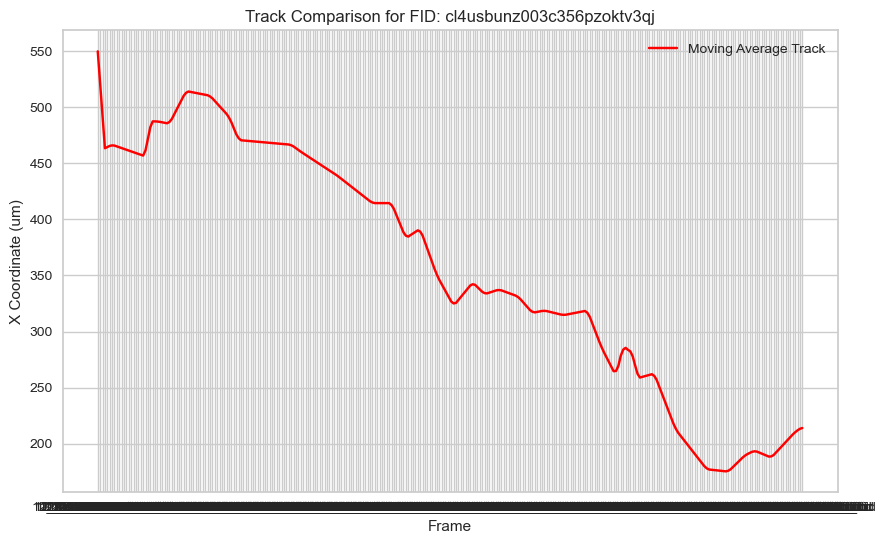

In [56]:
df = participant_dataframes['12']
selected_fid = 'cl4usbunz003c356pzoktv3qj'
plot_data = df[df['fid'] == selected_fid]
plt.figure(figsize=(10, 6))

# Plot original track
# plt.plot(plot_data['frame_name'], plot_data['center_x_um'], label='Original Track', color='blue')

# Plot moving average track
plt.plot(plot_data['frame_name'], plot_data['avg_center_x_um'], label='Moving Average Track', color='red')

plt.xlabel('Frame')
plt.ylabel('X Coordinate (um)')
plt.title(f'Track Comparison for FID: {selected_fid}')
plt.legend()
plt.show()


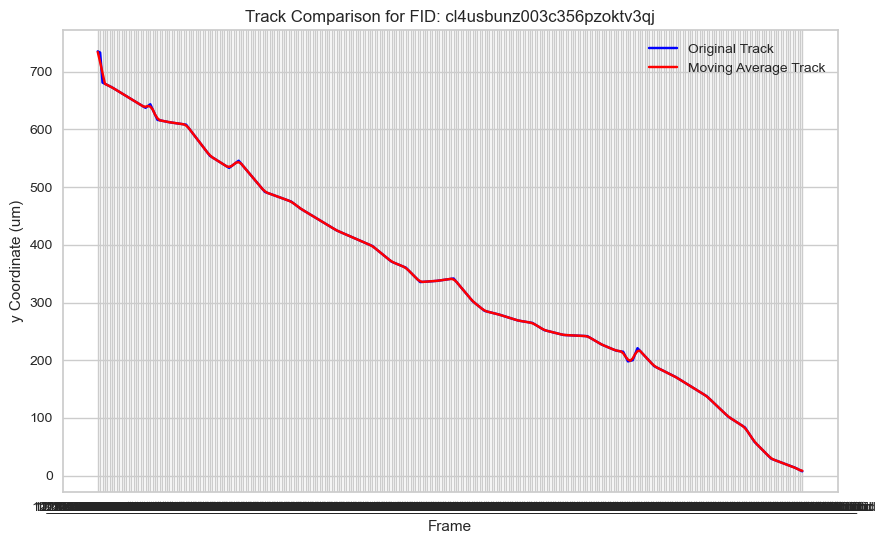

In [57]:
plt.figure(figsize=(10, 6))

# Plot original track
plt.plot(plot_data['frame_name'], plot_data['center_y_um'], label='Original Track', color='blue')

# Plot moving average track
plt.plot(plot_data['frame_name'], plot_data['avg_center_y_um'], label='Moving Average Track', color='red')

plt.xlabel('Frame')
plt.ylabel('y Coordinate (um)')
plt.title(f'Track Comparison for FID: {selected_fid}')
plt.legend()
plt.show()

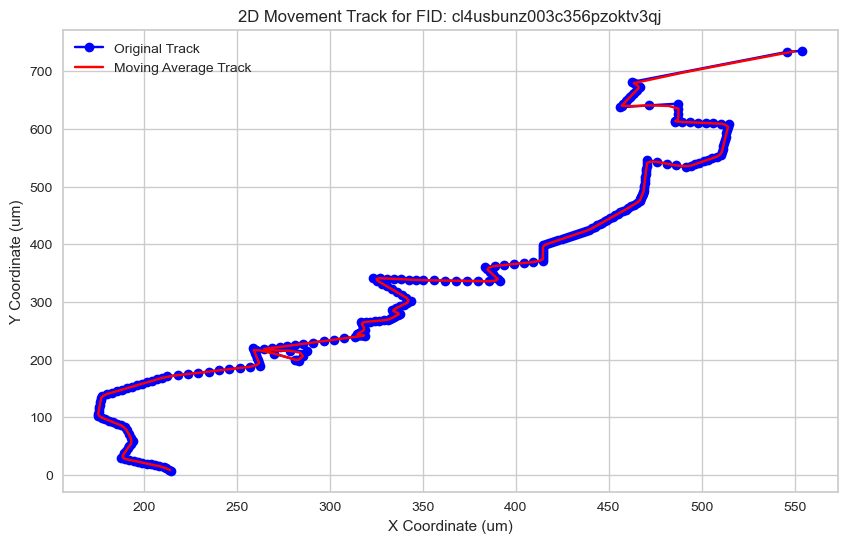

In [58]:
plt.figure(figsize=(10, 6))

# Plot original track
plt.plot(plot_data['center_x_um'], plot_data['center_y_um'], label='Original Track', color='blue', marker='o')

# Plot moving average track
plt.plot(plot_data['avg_center_x_um'], plot_data['avg_center_y_um'], label='Moving Average Track', color='red', marker='x')

plt.xlabel('X Coordinate (um)')
plt.ylabel('Y Coordinate (um)')
plt.title(f'2D Movement Track for FID: {selected_fid}')
plt.legend()
plt.show()


In [ ]:
# changing the riser function so that it compares segments from the actual track to the average track


def distance_between_segments(seg1_start, seg1_end, seg2_start, seg2_end):
    # Assuming distance_between_segments calculates the shortest distance between two line segments
    # This function should be defined to accurately calculate this distance
    pass

def calculate_segment_distances(df, window_size):
    # Add columns for segment start and end in actual and average tracks
    df['seg_actual_start'] = df[['center_x_um', 'center_y_um']].apply(tuple, axis=1)
    df['seg_actual_end'] = df[['center_x_um', 'center_y_um']].shift(-1).apply(tuple, axis=1)
    df['seg_avg_start'] = df[['avg_center_x_um', 'avg_center_y_um']].apply(tuple, axis=1)
    df['seg_avg_end'] = df[['avg_center_x_um', 'avg_center_y_um']].shift(-1).apply(tuple, axis=1)

    # Initialize a column to store the riser values
    df['riser'] = np.nan

    for fid, group in df.groupby('fid'):
        # Ensure group is sorted by frame_number or equivalent
        group = group.sort_values(by='frame_number')
        for j in range(len(group) - window_size):
            min_dist = float('inf')
            for k in range(j, j + window_size - 1):
                # Get the actual and average segments
                actual_start = group.iloc[k]['seg_actual_start']
                actual_end = group.iloc[k]['seg_actual_end']
                avg_start = group.iloc[j]['seg_avg_start']
                avg_end = group.iloc[j]['seg_avg_end']

                # Calculate the distance between segments
                dist = distance_between_segments(actual_start, actual_end, avg_start, avg_end)
                min_dist = min(min_dist, dist)
            
            # Assign the minimum distance to the riser column
            df.loc[group.index[j], 'riser'] = min_dist

    return df